In [1]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# Si vous voulez enregistrer/charger rapidement
import pickle

In [3]:
EXIOBASE_PATH = '../EXIOBASE/' # ne pas hésiter à changer

In [4]:
# Charger
with open(EXIOBASE_PATH + f'IOT_2000_ixi.pickle', 'rb') as handle:
    io2000 = pickle.load(handle)

In [5]:
# Charger
with open(EXIOBASE_PATH + f'IOT_2019_ixi.pickle', 'rb') as handle:
    io2019 = pickle.load(handle)

In [6]:
io = io2019.copy()

# Vérifier les émissions de N2O de l'industrie française
(à terminer)

In [7]:
imp = 'Climate change midpoint | ILCD recommended CF | Global warming potential 100 years'

In [8]:
GHG = ['CO2 - combustion - air',
        'CH4 - combustion - air',
        'N2O - combustion - air',
        'SOx - combustion - air',
        'NOx - combustion - air',
        'NH3 - combustion - air',
        'CO - combustion - air',
        'CH4 - non combustion - Extraction/production of (natural) gas - air',
        'CH4 - non combustion - Extraction/production of crude oil - air',
        'CH4 - non combustion - Mining of antracite - air',
        'CH4 - non combustion - Mining of bituminous coal - air',
        'CH4 - non combustion - Mining of coking coal - air',
        'CH4 - non combustion - Mining of lignite (brown coal) - air',
        'CH4 - non combustion - Mining of sub-bituminous coal - air',
        'CH4 - non combustion - Oil refinery - air',
        'CO2 - non combustion - Cement production - air',
        'CO2 - non combustion - Lime production - air',
        'SF6 - air',
        'CH4 - agriculture - air',
        'CO2 - agriculture - peat decay - air',
        'N2O - agriculture - air',
        'CH4 - waste - air',
        'CO2 - waste - biogenic - air',
        'CO2 - waste - fossil - air',
      ]

In [9]:
io.satellite.D_cba.loc['CO2 - combustion - air', ]

region  sector                                             
AT      Cultivation of paddy rice                              4.435594e+06
        Cultivation of wheat                                   1.259699e+08
        Cultivation of cereal grains nec                       1.501806e+08
        Cultivation of vegetables, fruit, nuts                 5.473989e+08
        Cultivation of oil seeds                               1.426003e+08
                                                                   ...     
WM      Activities of membership organisation n.e.c. (91)      7.413850e+09
        Recreational, cultural and sporting activities (92)    1.481543e+10
        Other service activities (93)                          9.159448e+09
        Private households with employed persons (95)          2.995173e+08
        Extra-territorial organizations and bodies             0.000000e+00
Name: CO2 - combustion - air, Length: 7987, dtype: float64

In [10]:
(io2019.satellite.D_pba_reg - io2000.satellite.D_pba_reg).loc[['N2O - combustion - air','N2O - agriculture - air']]['FR']

stressor
N2O - combustion - air    -1.446059e+06
N2O - agriculture - air    1.492117e+07
Name: FR, dtype: float64

In [11]:
(io2019.satellite.D_cba_reg - io2000.satellite.D_cba_reg).loc[['N2O - combustion - air','N2O - agriculture - air']]['FR']

stressor
N2O - combustion - air    -1.344387e+06
N2O - agriculture - air    2.063240e+07
Name: FR, dtype: float64

# Estimer les émissions dues à l'automobile pour les ménages

L'idée est d'essayer de reproduire le calcul d'émissions de cycle de vie pour l'automobile. L'approche "bottom-up" prend en compte la production d'un véhicule, son utilisation, ainsi que la phase amont du carburant/de l'électricité. Il faut donc associer à ces étapes un ou des secteurs d'EXIOBASE.

In [12]:
ind = 'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'

In [13]:
# Faisons la liste des secteurs qui nous intéressent
# On peut avoir une idée en allant voir io.Y['FR','Final consumption expenditure by households'].nlargest(20)

prod_voiture = ['Manufacture of motor vehicles, trailers and semi-trailers (34)',
                'Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries']
prod_carburant = ['Petroleum Refinery',
                  'Retail sale of automotive fuel']

In [14]:
# ne garder que les lignes (secteurs) de demande correspondant aux émissions amont

indices_amont = io.Y.index.get_level_values(1).isin(prod_voiture+prod_carburant)

In [15]:
# prendre ces lignes, pour la France, et multiplier par leurs facteurs d'impact "consumption-based"
# c'est-à-dire les facteurs "M" (par opposition à "S", les facteurs d'impact "directs" ou production-based)
# pour rappel M * y (la demande) = S * x (la production totale) pour l'ensemble de la table IO

emissions_amont = io.Y[indices_amont]['FR'].mul(io.impacts.M.loc[ind], axis=0).dropna()

In [16]:
# émissions par personne

emissions_amont_cap = emissions_amont.groupby('sector').sum()/io.population.loc['population','FR']

In [17]:
emissions_amont_cap.sum().sum()

900.3364350571942

On aurait donc 900 kg CO2 eq. par personne et par an émis à cause de la consommation de véhicules et de carburant par les ménages et l'administration. 

Prenons l'hypothèse très conservatrice que l'ensemble des émissions directes des ménages et de l'administration (`F_Y`) ne concerne que la voiture (en réalité, ces émissions incluent aussi les rejets de CO2 dus au chauffage au gaz et au fioul). Appelons ces émissions les émissions "aval" de la voiture.

In [18]:
emissions_aval_cap = io.impacts.F_Y.loc[ind,'FR']/io.population.loc['population','FR']

In [19]:
emissions_aval_cap.name = 'Direct emissions'
emissions_aval_cap.sum()

1125.390264855827

In [20]:
emissions_voiture_cap = emissions_amont_cap.append(emissions_aval_cap)

C:\Users\Gibon\AppData\Local\Temp\ipykernel_65152\1598574051.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emissions_voiture_cap = emissions_amont_cap.append(emissions_aval_cap)


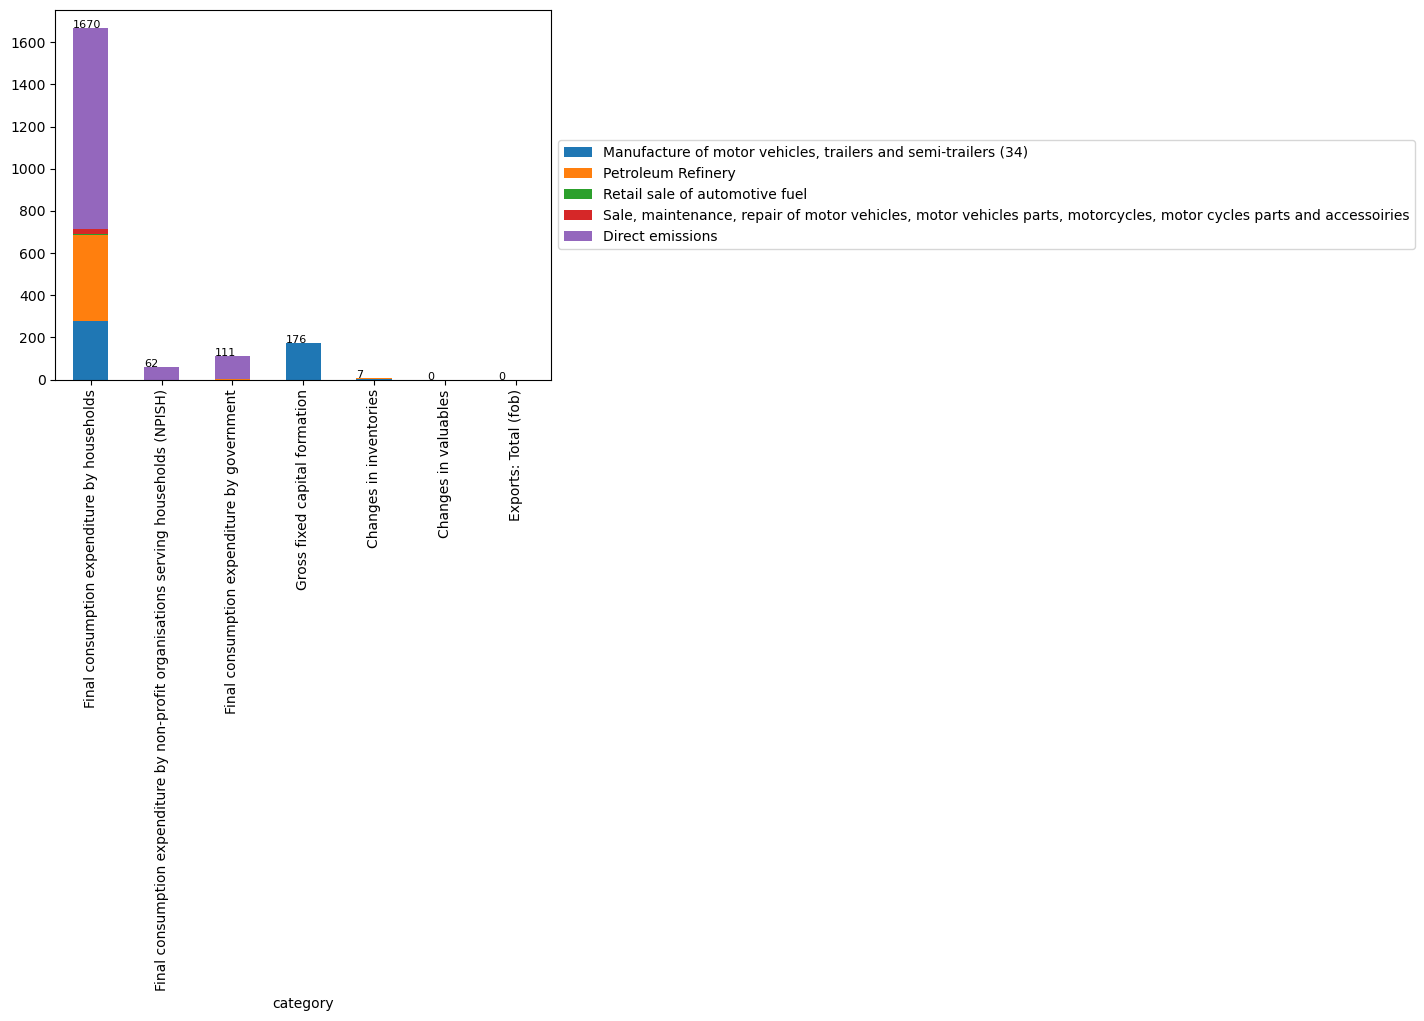

In [21]:
ax = emissions_voiture_cap.T.plot.bar(stacked=True)

for p,v in zip(ax.patches, emissions_voiture_cap.sum()):
    ax.annotate(f'{v:.0f}', (p.get_x(), v), fontsize=8)
    
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

En tout état de cause, et même en "râtissant large" (= en incluant les émissions normalement non-allouées aux ménages), ces émissions sont relativement basses comparées aux kilomètres parcourus par an en voiture en France. Carbone4 donne une empreinte d'environ 2030 kg CO2 eq. par personne et par an.

![title](https://www.carbone4.com/files/graphique_final.png)

Il y a sûrement plusieurs points qui peuvent expliquer cette différence:

- l'allocation des émissions dans EXIOBASE pose question: on trouve que les ménages consomment par exemple de l'acier, il y a probablement des effets indésirables dus aux algorithmes d'allocation des dépenses.

- dans l'empreinte individuelle on a tendance à compter l'ensemble de ses déplacements en voiture, alors qu'une partie est en fait allouée aux entreprises (à savoir si les statistiques sous-jacentes comptent par exemples les trajets domicile-travail comme appartenant au périmètre de l'entreprise)

- les émissions directes sont calculées par rapport au volume des différentes énergies vendues au sein du pays (fioul, gaz, ...) ce qui ne correspond pas nécessairement aux volumes d'émissions dues à la combustion par les ménages.

Le dernier point peut être vérifié, ce qui est fait ci-après.

In [22]:
# Consommation voitures et carburants de l'économie française

emissions_amont_economie = io.Z['FR'].sum(1).loc[indices_amont].mul(io.impacts.M.loc[ind], axis=0).dropna()

In [23]:
emissions_amont_economie_cap = emissions_amont_economie.groupby('sector').sum()/io.population.loc['population','FR']

In [24]:
emissions_voiture_cap['Consommation intermédiaire']=emissions_amont_economie_cap

In [25]:
emissions_voiture_cap

category,Final consumption expenditure by households,Final consumption expenditure by non-profit organisations serving households (NPISH),Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories,Changes in valuables,Exports: Total (fob),Consommation intermédiaire
sector,,,,,,,,
"Manufacture of motor vehicles, trailers and semi-trailers (34)",276.437775,0.000583,0.290256,174.146192,2.816347,0.0,0.0,48.664110
Petroleum Refinery,408.955458,0.001598,0.835346,0.338672,3.405151,0.0,0.0,357.805403
Retail sale of automotive fuel,3.463605,0.009935,0.291375,0.410098,0.209365,0.0,0.0,11.812043
"Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries",26.927760,0.048591,0.548602,1.002286,0.197443,0.0,0.0,16.042173
Direct emissions,954.121063,62.022197,109.247005,0.000000,0.000000,0.0,0.0,NaN


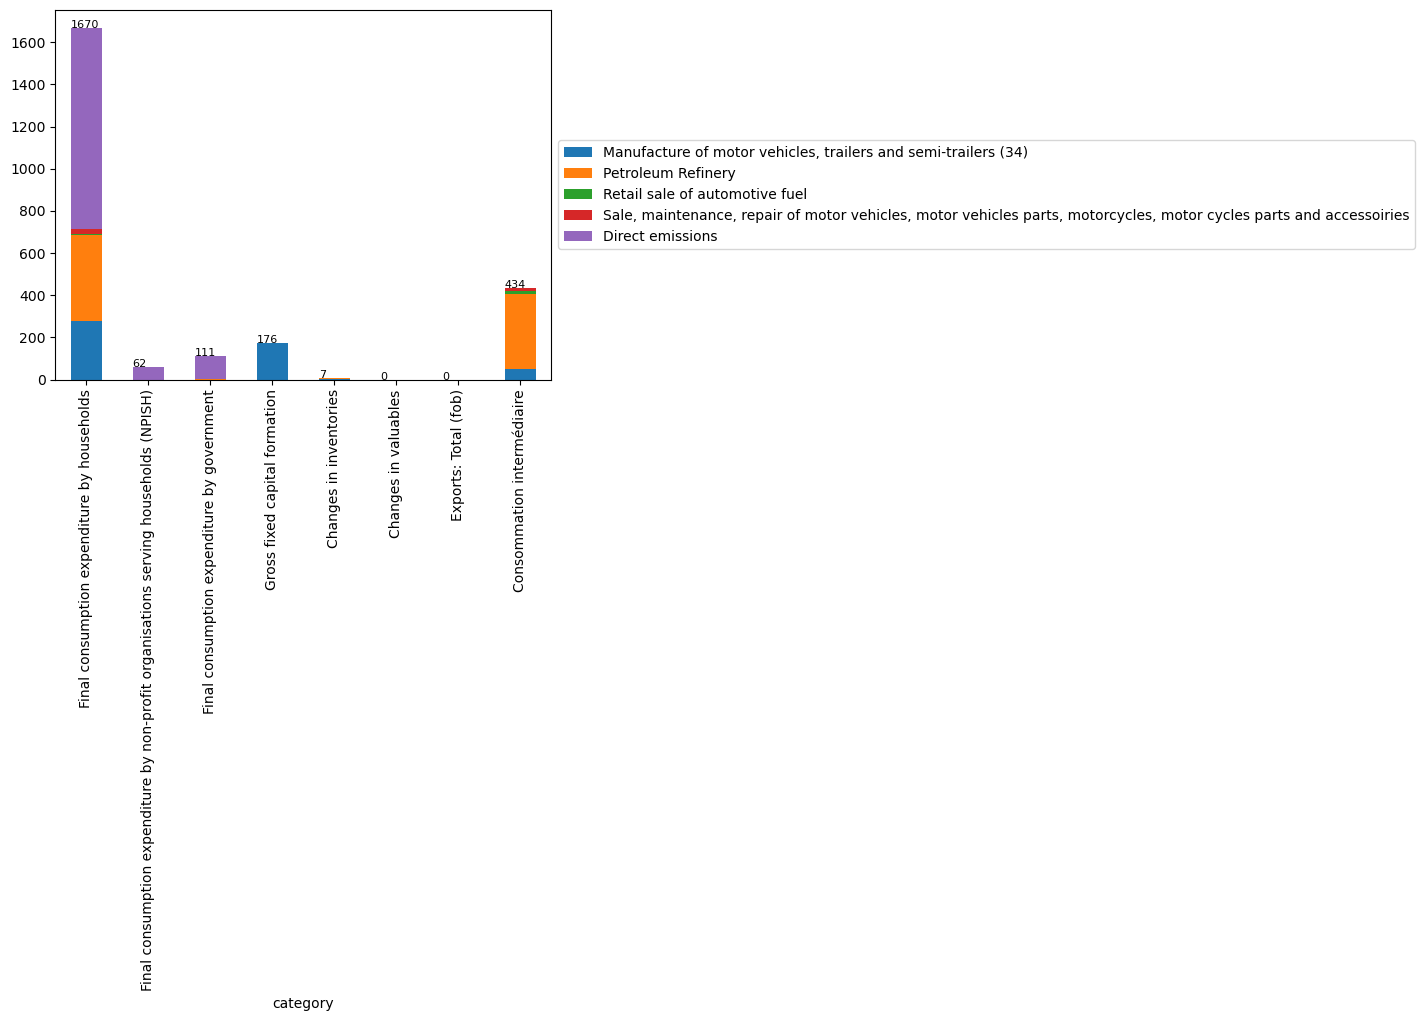

In [26]:
ax = emissions_voiture_cap.T.plot.bar(stacked=True)

for p,v in zip(ax.patches, emissions_voiture_cap.sum()):
    ax.annotate(f'{v:.0f}', (p.get_x(), v), fontsize=8)
    
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [27]:
emissions_voiture_cap.sum().sum()

2460.050429102516

La somme totale des postes d'émissions comptabilisés jusqu'ici atteint 2.46 t CO2 eq. Il faudrait ajouter les émissions directes dues à l'utilisation des véhicules des parcs d'entreprise (on pourrait par exemple appliquer un ratio émissions/consommation de carburant), et retirer les émissions directes dues aux autres activités (le chauffage pour les ménages et l'administration). Au final, on voit que les chiffres dus à la voiture sont plus ou moins cohérents, mais surtout qu'il y a un manque de détails dans EXIOBASE.